This module is meant to run a bunch of tests comparing the Fourier matrix elements of AMR waves on some arbitrary AMR grid. I recommend comparing the results in cell 13 between even and odd numbers for `refCells`.

In [1]:
import os.path
from scipy import *
import numpy as np
from numpy import *
from numpy import linalg as LA
from scipy import linalg as LA2
import sympy as sympy
import sys as sys
from fractions import Fraction
import time
import matplotlib.pyplot as plt
import itertools as it
from IPython.core.display import HTML
from fractions import Fraction


sys.path.append('/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/')
from Modules import BasicTools as BT
from Modules import WaveTools as WT
from Modules import PlotTools as PT
from Modules import FFTTools as FFTT
from Modules import OperatorTools as OT
from Modules import GridTransferTools as GTT
from Modules import TestTools as TT
from Modules import SolverTools as ST
from Modules import WaveformTools as WFT

display(HTML("<style>pre { white-space: pre !important; }</style>"))
np.set_printoptions( linewidth = 10000, threshold = 100000)

This cell is for all the input variables. `nh` is the number of coarse cells; `refCells` is the number of coarse cells on which you want to refine.

In [2]:
nh = 32
refRatio = 2
refCells = 13
Hans = False
prenorm = False

omega = BT.Grid(nh)
finehalf = list(np.arange(refCells))
omega.AddPatch(refRatio, finehalf)

In [3]:
def KSpace(omega):
    nh_min = omega.nh_min
    degFreed = omega.degFreed
    x = omega.xNode
    hs = omega.h
    ks = np.arange(nh_min + 1)[1:]
    sj = np.zeros((2 * degFreed, nh_min), float)
    for j in range(degFreed):
        sj[2 * j, :] = np.cos(2. * np.pi * ks * (x[j] + (hs[j] / 2.))) * np.sin(np.pi * hs[j] * ks) / (np.pi * hs[j] * ks)
        sj[(2 * j) + 1, :] = np.sin(2. * np.pi * ks * (x[j] + (hs[j] / 2.))) * np.sin(np.pi * hs[j] * ks) / (np.pi * hs[j] * ks)
    Sjcos = sum(abs(sj[::2]), axis = 0)
    Sjsin = sum(abs(sj[1::2]), axis = 0)
    return ks, sj, Sjcos, Sjsin

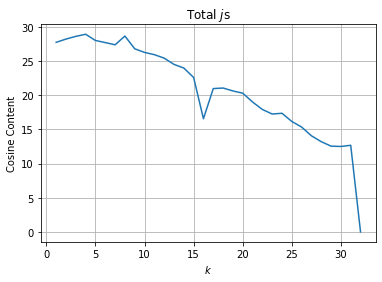

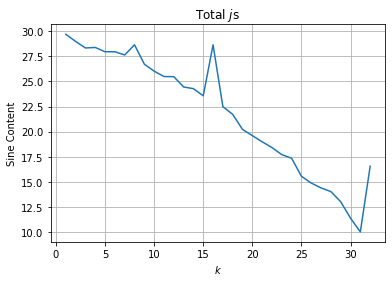

[2.77282531e+01 2.82051092e+01 2.85990583e+01 2.89115863e+01 2.79995865e+01 2.76934144e+01 2.73672147e+01 2.86478898e+01 2.67846371e+01 2.62534479e+01 2.59265554e+01 2.54178687e+01 2.45019320e+01 2.39711682e+01 2.25916642e+01 1.65521141e+01 2.09627706e+01 2.10450854e+01 2.06186459e+01 2.02924926e+01 1.90069644e+01 1.79109688e+01 1.72424979e+01 1.73520380e+01 1.61569492e+01 1.53358104e+01 1.40589908e+01 1.31991131e+01 1.25441967e+01 1.24970672e+01 1.26693760e+01 3.89899935e-14]
[29.69943086 28.98576534 28.33302375 28.38419321 27.95589326 27.95363317 27.63540123 28.64788976 26.72329172 26.01978095 25.49004787 25.47427703 24.44784646 24.28082414 23.56717884 28.64788976 22.48928263 21.719038   20.22383821 19.60608454 18.99118026 18.41459926 17.71411528 17.35203799 15.55988588 14.87984014 14.40027196 14.0319933  13.02108496 11.3882054  10.01712868 16.55211408]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32]



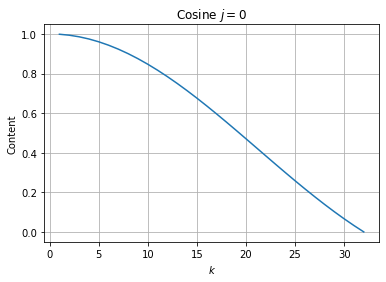

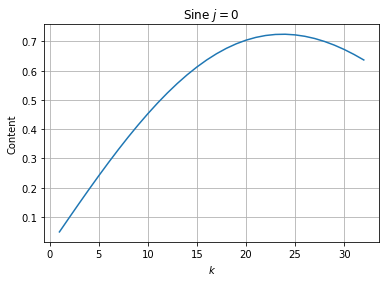

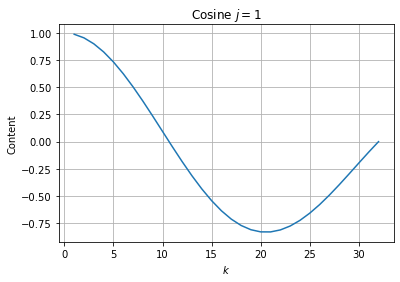

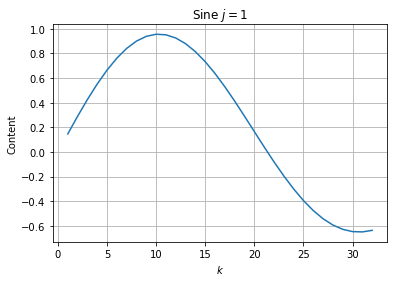

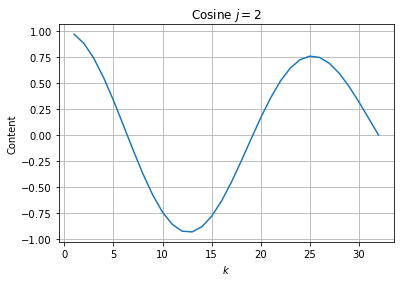

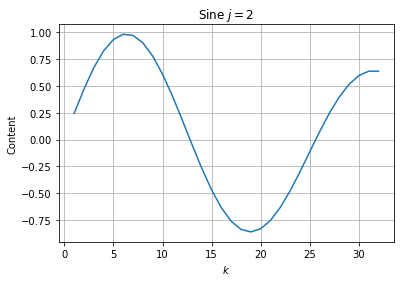

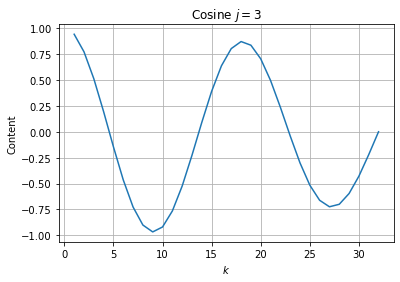

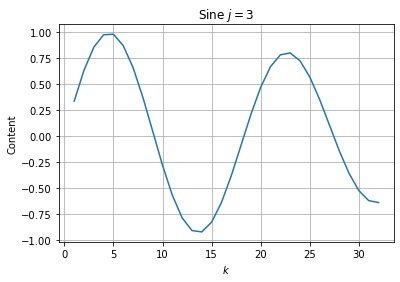

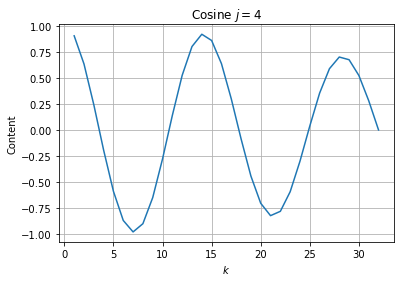

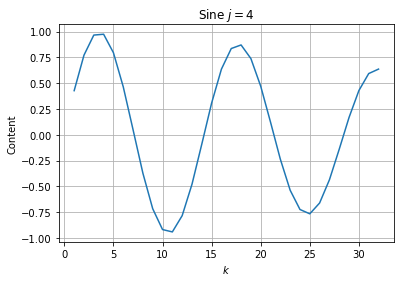

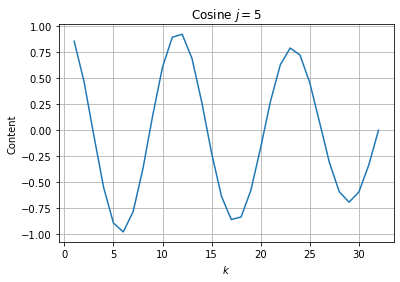

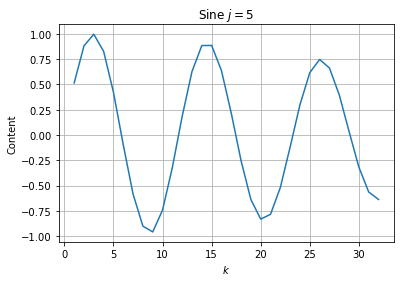

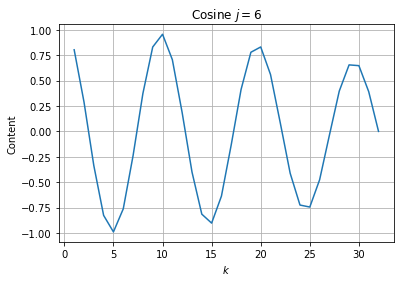

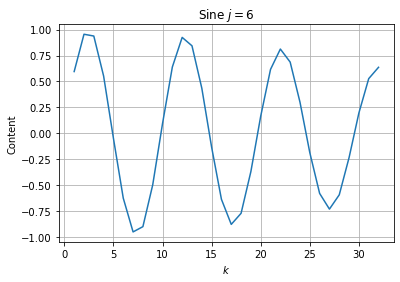

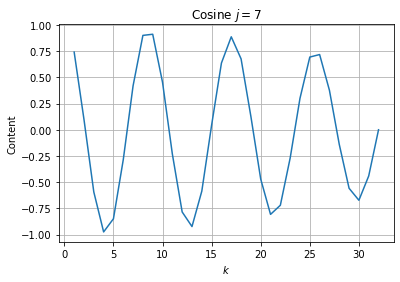

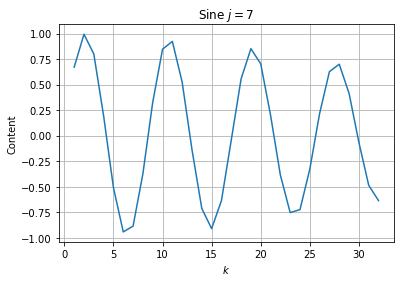

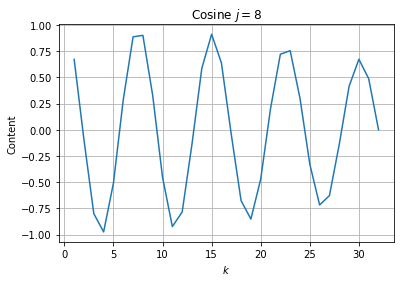

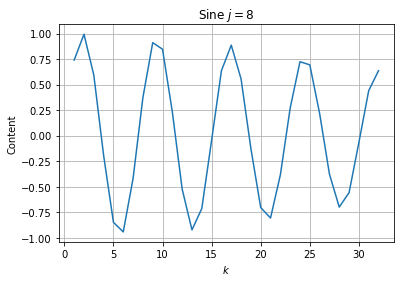

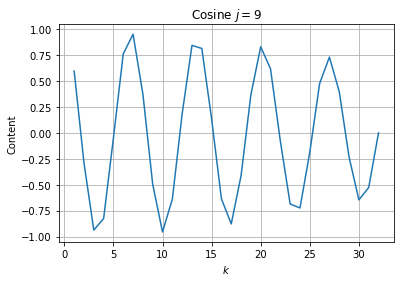

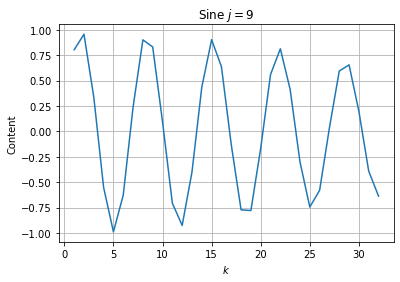

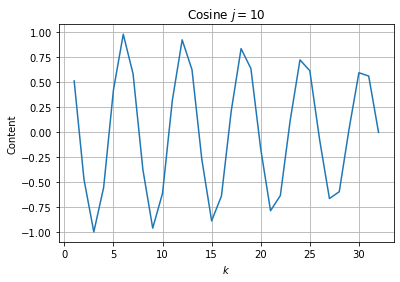

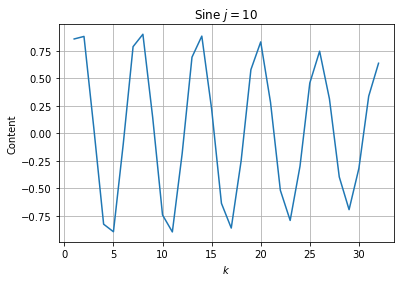

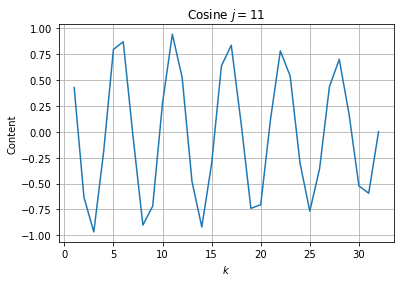

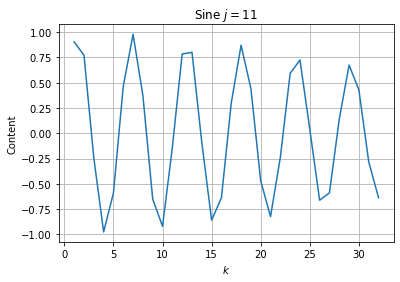

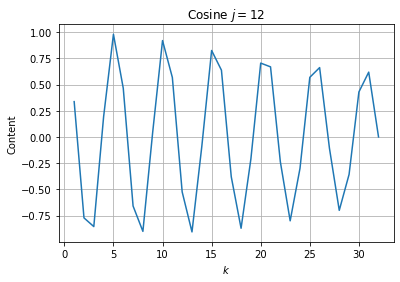

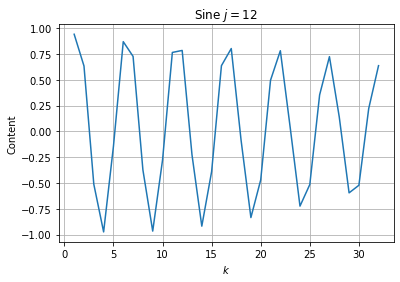

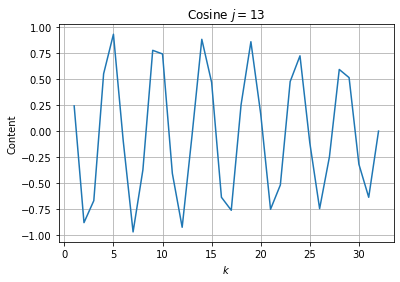

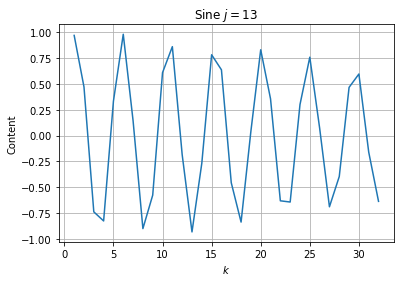

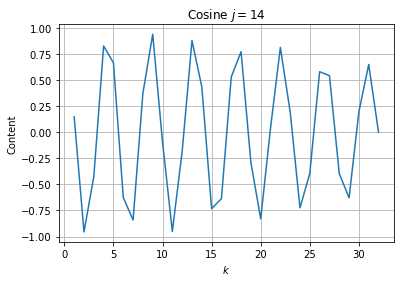

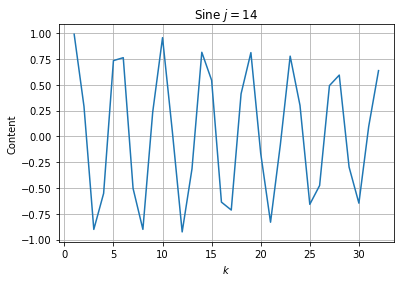

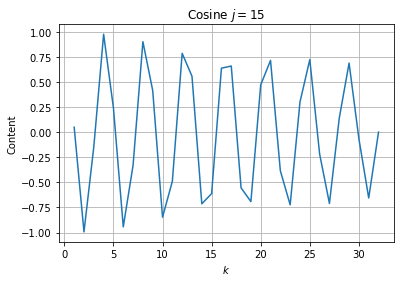

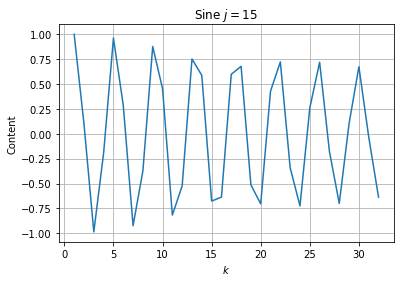

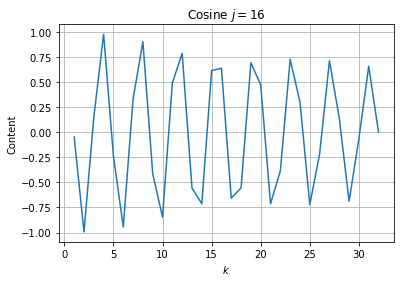

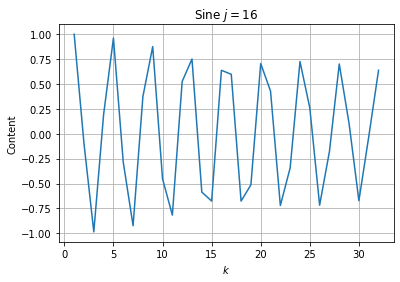

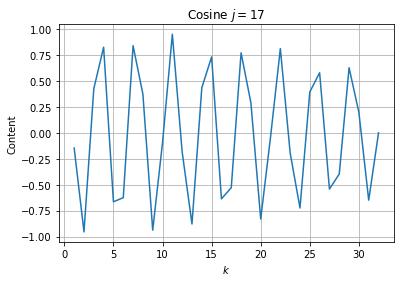

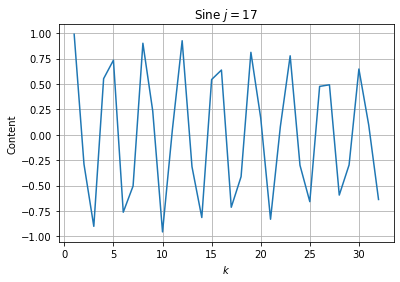

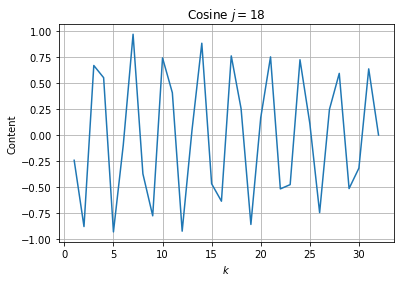

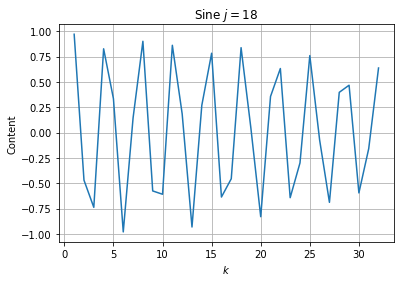

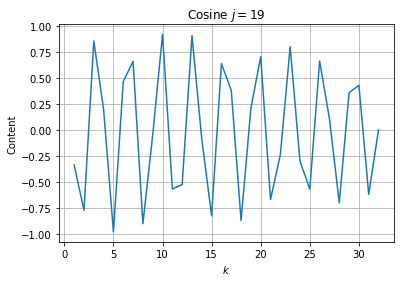

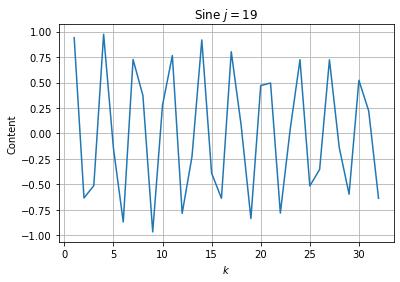

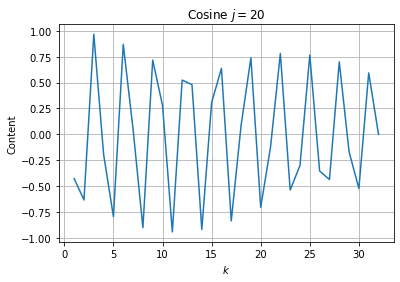

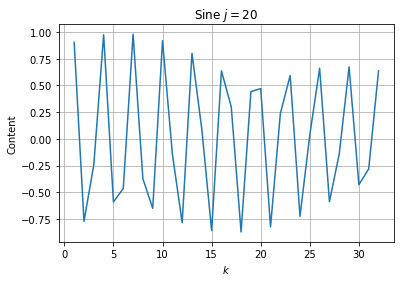

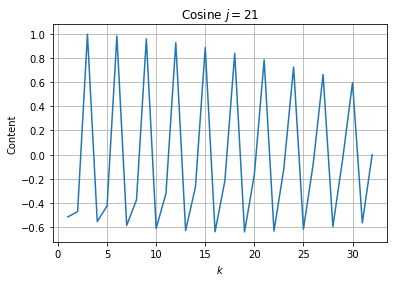

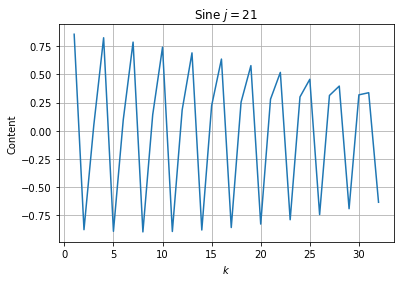

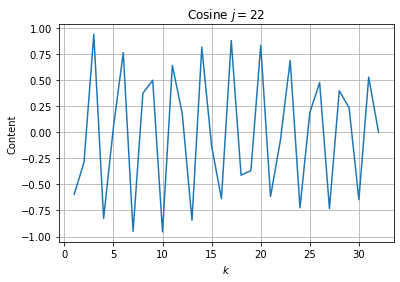

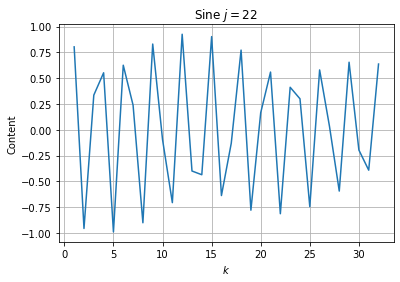

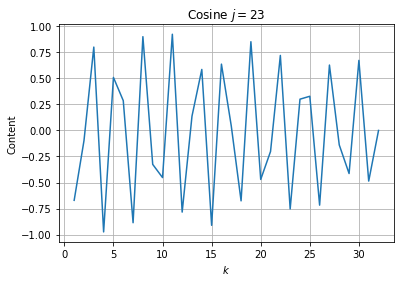

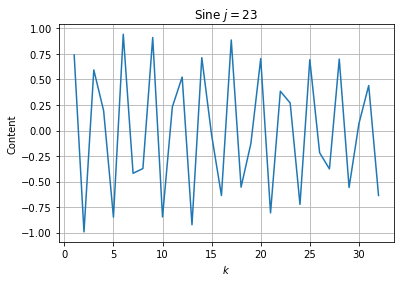

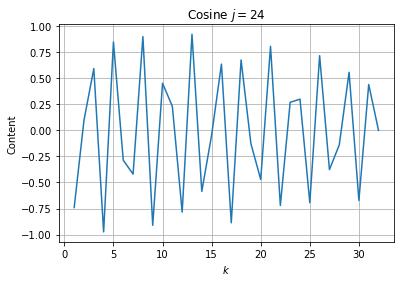

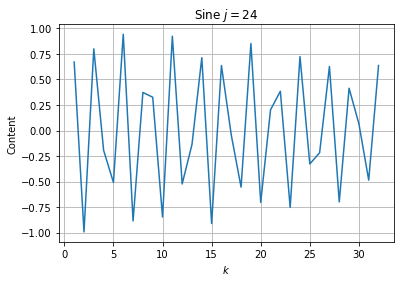

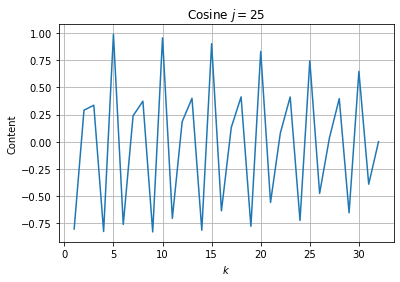

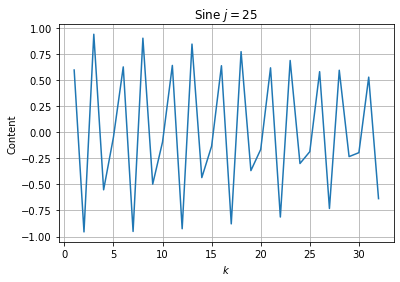

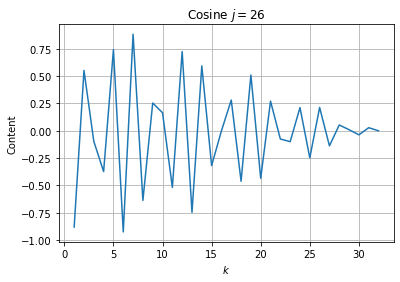

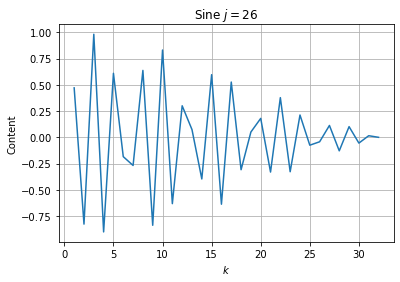

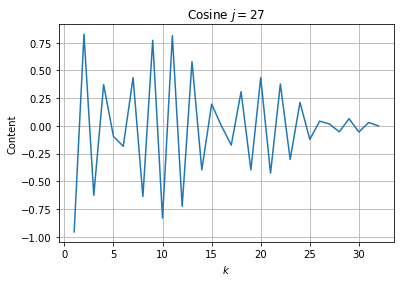

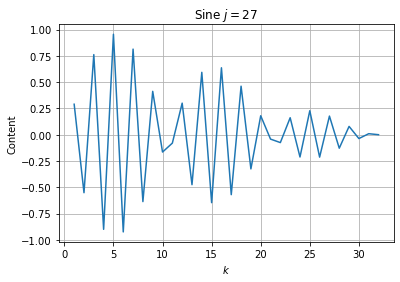

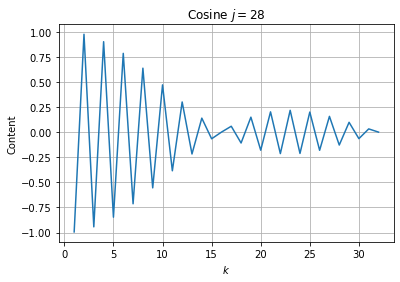

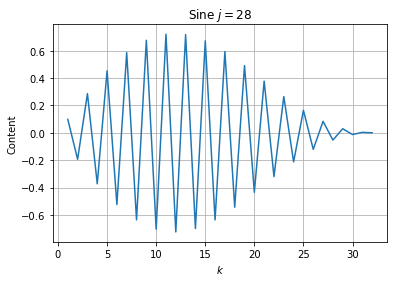

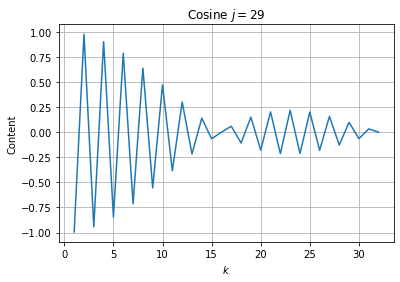

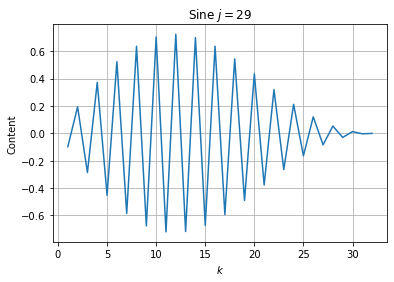

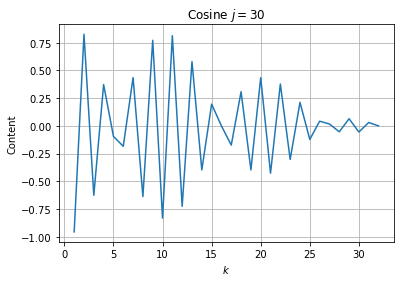

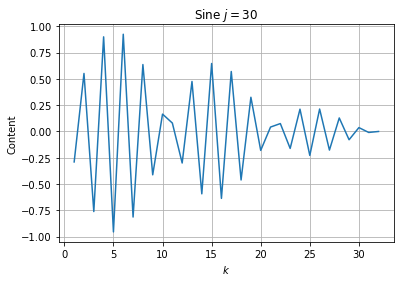

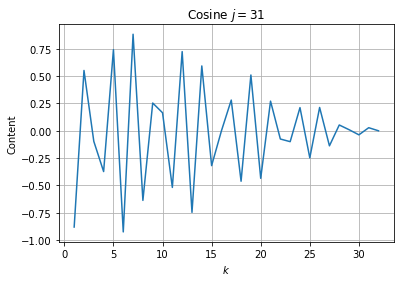

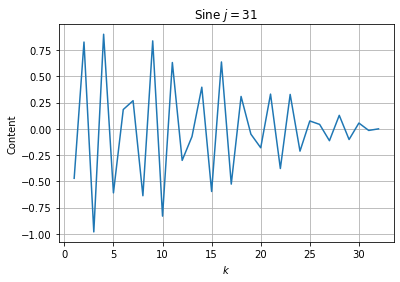

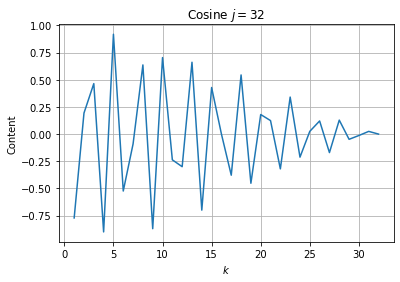

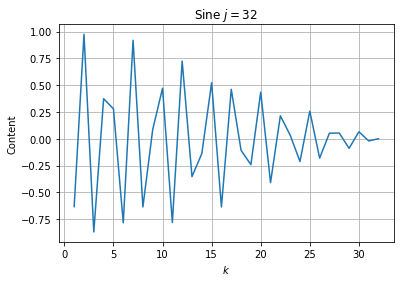

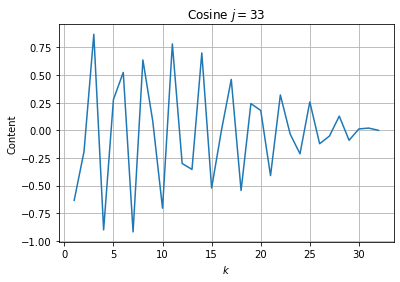

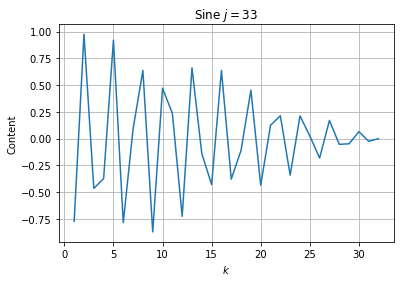

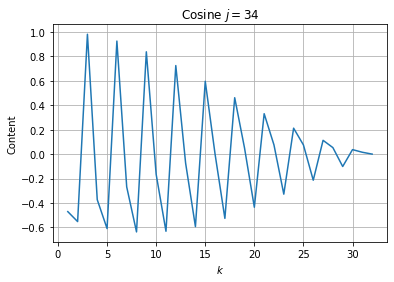

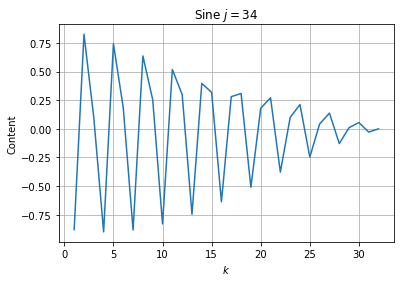

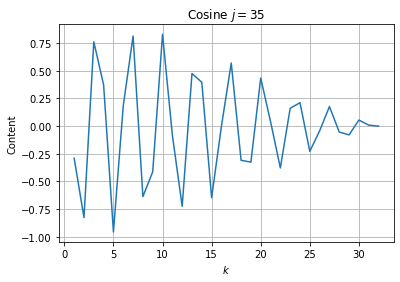

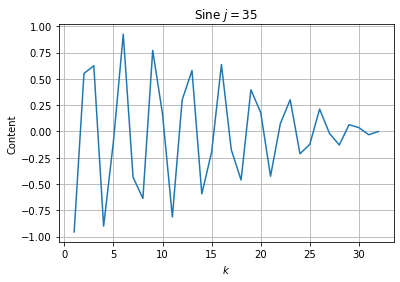

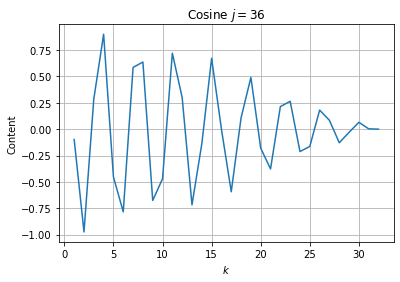

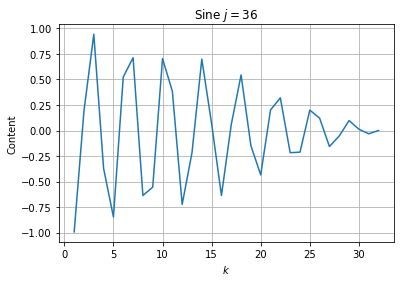

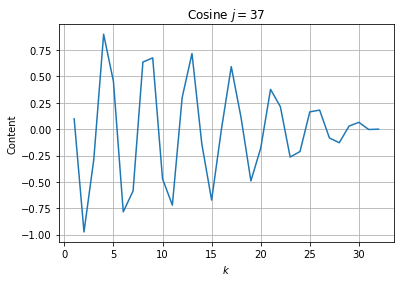

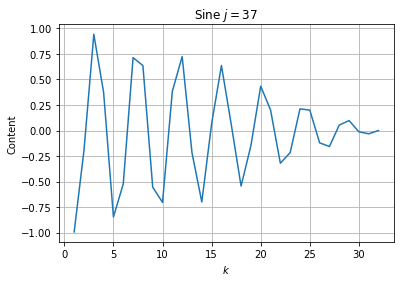

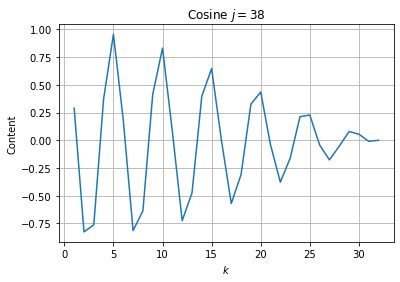

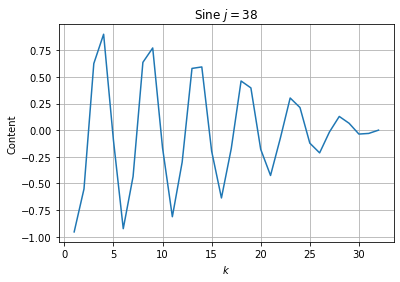

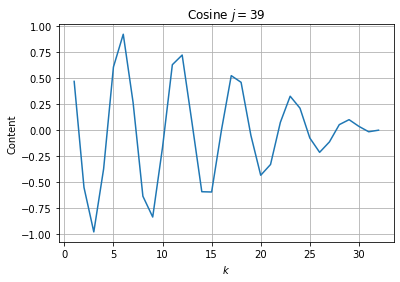

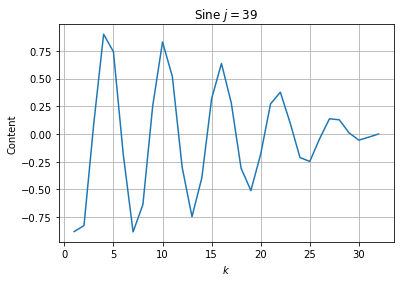

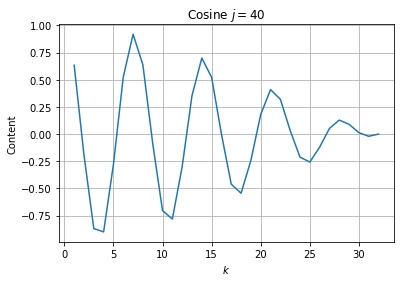

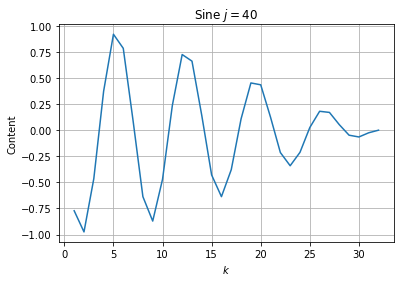

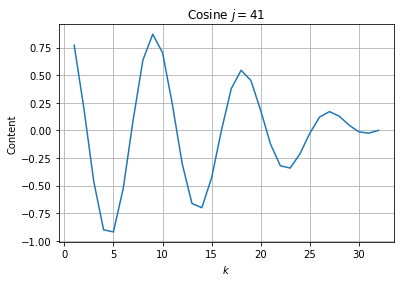

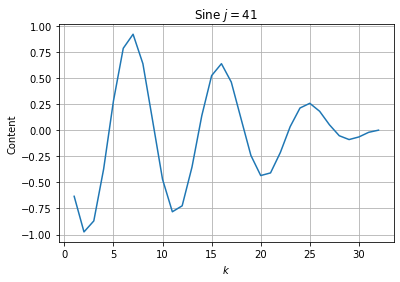

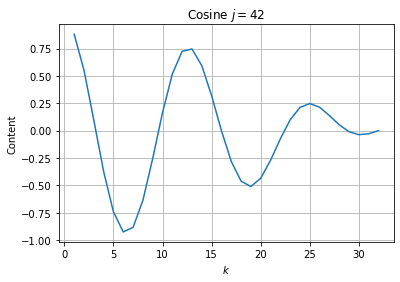

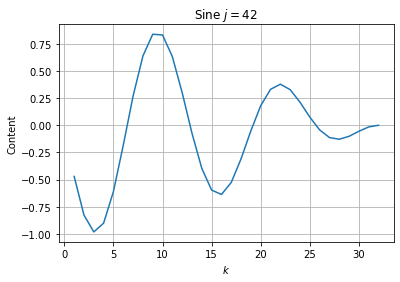

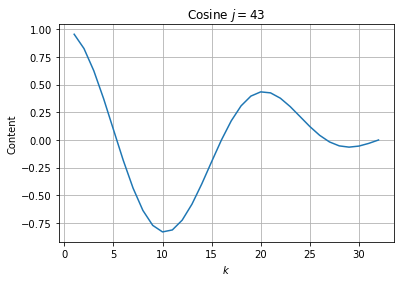

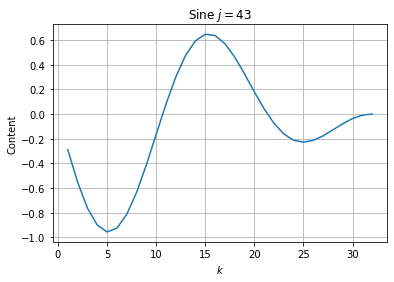

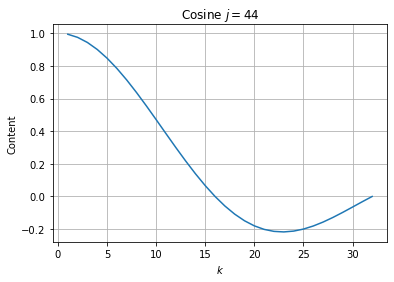

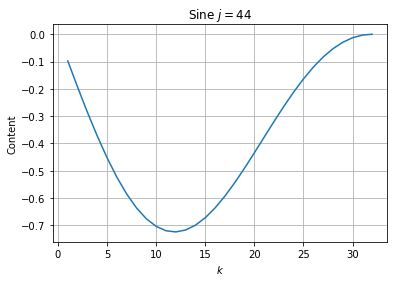

In [4]:
degFreed = omega.degFreed

ks, sj, Sjcos, Sjsin = KSpace(omega)
fig, ax = plt.subplots()#figsize = [12, 10])
plt.plot(ks, Sjcos)
plt.title(r'Total $j$s')
plt.xlabel(r'$k$')
plt.ylabel('Cosine Content')
ax.grid(True, zorder = 0)
plt.show()

ks, sj, Sjcos, Sjsin = KSpace(omega)
fig, ax = plt.subplots()#figsize = [12, 10])
plt.plot(ks, Sjsin)
plt.title(r'Total $j$s')
plt.xlabel(r'$k$')
plt.ylabel('Sine Content')
ax.grid(True, zorder = 0)
plt.show()

print(Sjcos)
print(Sjsin)
print(ks)
print('')
for j in range(degFreed):
    fig, ax = plt.subplots()#figsize = [12, 10])
    plt.plot(ks, sj[2 * j, :])
    plt.title(r'Cosine $j = %d$' %j)
    plt.xlabel(r'$k$')
    plt.ylabel('Content')
    ax.grid(True, zorder = 0)
    # saveName = '/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/Figures/xvsx_0_' + str(nt)
    # fig.savefig(saveName + '.png', bbox_inches = 'tight')
    plt.show()
    
    fig, ax = plt.subplots()#figsize = [12, 10])
    plt.plot(ks, sj[(2 * j) + 1, :])
    plt.title(r'Sine $j = %d$' %j)
    plt.xlabel(r'$k$')
    plt.ylabel('Content')
    ax.grid(True, zorder = 0)
    # saveName = '/Users/sashacurcic/SashasDirectory/ANAG/FV_MG/Figures/xvsx_0_' + str(nt)
    # fig.savefig(saveName + '.png', bbox_inches = 'tight')
    plt.show()

In [5]:
# ----------------------------------------------------------------------------------------------------------------
# Function: Normalization
# ----------------------------------------------------------------------------------------------------------------
# By: Sasha Curcic
#
# This function finds the inner product of an input matrix with itself, outputs that inner product matrix, and
# then prints to screen a bunch of tests on that inner product matrix. The first test is for symmetry; if WTW is
# symmetric, then this should be a matrix of zeros. The next is the inverse. The next is the symmetry of the
# inverse. The next two are WTW left- and right-multiplied by its inverse. The last three are the determinant,
# eigenvalues, and eigenvectors of WTW. If WTW contains an eigenvalue of zero, the eigenvector corresponding to
# that eigenvalue is also output to screen; this consitutes the nullspace of WTW.
# ----------------------------------------------------------------------------------------------------------------
# Input:
#
# waves               (N x M) real        Matrix of wave vectors
# ----------------------------------------------------------------------------------------------------------------
# Output:
#
# WTWinv              (M x M) real        A positive non negative number given by the user
# ----------------------------------------------------------------------------------------------------------------

In [6]:
def TestThings(WTW):
    det = LA.det(WTW)
    sym = WTW - WTW.transpose()
    WTWinv = LA.inv(WTW)
#     WWTW = waves @ WTWinv
    syminv = WTWinv - WTWinv.transpose()
    ID1 = WTWinv @ WTW
    ID2 = WTW @ WTWinv
    eigvals, eigvecs = LA.eig(WTW)
    eigvals = abs(np.round(eigvals, 12))
    condition = False
    if (any(eigvals == 0)):
        condition = True
        index = np.where(abs(np.round(eigvals, 12)) == 0)[0]
        zeroVec = eigvecs[:, index]
    
    np.set_printoptions(precision=24, suppress=True)
    
#     print('W(W^TW)^-1 =')
#     print(np.round(WWTW, 14))
    print('')
    print('symmetry of W^TW:')
    print(np.round(sym, 14))
    print('')
    print('(W^TW)^-1:')
    print(np.round(WTWinv, 14))
    print('')
    print('symmetry of (W^TW)^-1:')
    print(np.round(syminv, 14))
    print('')
    print('identity 1:')
    print(np.round(ID1, 14))
    print('')
    print('identity 2:')
    print(np.round(ID2, 14))
    print('')
    print('determinant =', det)
    print('')
    print('eigenvalues:')
    print(np.round(eigvals, 14))
    print('')
    print('eigenvectors:')
    print(eigvecs)#np.round(eigvecs, 12))
    if (condition):
        print('')
        print('nullspace of W^TW:')
        print(np.round(zeroVec, 12))
    print('')
    
    return WTWinv

In [7]:
def Normalization(waves):
    WTW = waves.transpose() @ waves
    print('')
    print('W^TW:')
    print(np.round(WTW, 14))
    WTWinv = TestThings(WTW)
    return WTWinv

In [8]:
# ----------------------------------------------------------------------------------------------------------------
# Function: DotEach
# ----------------------------------------------------------------------------------------------------------------
# By: Sasha Curcic
#
# This function finds the inner products of each pair of vectors in the input matrix and prints them to screen.
# ----------------------------------------------------------------------------------------------------------------
# Input:
#
# waves               (N x M) real        Matrix of wave vectors
# ----------------------------------------------------------------------------------------------------------------

In [9]:
def DotEach(waves):
    iters = np.shape(waves)[1]
    print(np.round(waves, 14))
    print('')
    for k in range(iters):
        for j in range(k, iters):
            dotprod = np.round(waves[:, k].transpose() @ waves[:, j], 14)
            print(str(k) + ' dot ' + str(j) + ': ' + str(dotprod))
            print('')
    return

In [10]:
def Prenormalize(omega, waves):
    degFreed = omega.degFreed
    hs = omega.h
    nhs = omega.nh
    nh_max= omega.nh_max
    dim = np.shape(waves)
    newWaves = np.zeros(dim, float)
    print('waves:')
    print(waves)
    print('')
    for nh in nhs:
        alias = int(nh_max / nh)
        omegah = BT.Grid(nh, alias = alias)
        wavesh = WT.MakeWaves(omegah)
        norm = np.diag(np.diag(np.round(wavesh.transpose() @ wavesh, 14) ** -1))
        norm[norm == inf] = 0#np.round(LA.inv(prenorm), 14)
        print('nh:')
        print(nh)
        print('')
        h = 1. / nh
        stripLoc = np.where(hs == h)[0]
        antipiece = waves + 0
        antipiece[stripLoc, :] = 0
        piece = (waves - antipiece) @ norm
        print('antipiece:')
        print(antipiece)
        print('')
        print('piece:')
        print(piece)
        print('')
        print('norm:')
        print(norm)
        print('')
        newWaves = newWaves + piece
    waves = newWaves
    print('newWaves:')
    print(waves)
    print('')
    return

This cell instantiates the AMR and the fine grid and finds the AMR and fine waves as well as the nullspace.

In [11]:
finehalf = list(np.arange(refCells))
omega = BT.Grid(nh)
omega.AddPatch(refRatio, finehalf)
nh_max = omega.nh_max
degFreed = omega.degFreed
omegaF = BT.Grid(nh_max)

waves = WT.MakeWaves(omega)
wavesF = WT.MakeWaves(omegaF)
nullspace = OT.FindNullspace(omega, waves, Hans = Hans)

if (prenorm):
    Prenormalize(omega, waves)

wavesMod = waves @ nullspace
wavesFMod = wavesF @ nullspace
restrictOp = GTT.CoarsenOp(omega)



This cell plots the waves in the nullspace.

In [12]:
FCoefF = np.zeros(nh_max, float)
FCoefF[-1] = 1
waveformAMR = restrictOp @ wavesF @ FCoefF
FCoefAMR = FFTT.FourierCoefs(wavesMod, waveformAMR)
print(FCoefAMR)
# PT.PlotWaves(omega, waves = waves, nullspace = nullspace)
# PT.PlotMixedWave(omega, waves = waves, FCoefs = nullspace @ FCoefAMR)
print('\n\n\n\n\n\n\n\n\n\n')
# PT.PlotWaves(omegaF, waves = wavesF)

[-1.81313298e-14 -2.43567472e-03  5.59364514e-03  8.72544825e-03  7.26485903e-03 -8.28335845e-03  8.35750632e-03  8.65993017e-03  1.23049495e-02  1.72722886e-03 -1.97254409e-04 -5.92889895e-03  8.62665652e-03  1.68243481e-02  5.28867413e-03 -5.22287652e-03  6.81213684e-03  1.96604412e-02  2.07227449e-02  6.30203687e-03 -2.43917652e-03 -2.79303699e-03  2.42306996e-02  2.73736831e-02  1.00318581e-02 -5.26367064e-03  5.28799112e-03  3.39883829e-02  3.68910119e-02  5.29615274e-02 -1.52474724e-02  6.97913949e-14  2.23322423e-01  5.61897506e-01 -4.41642646e-01 -6.08141388e-02 -6.48979409e-05  2.45437136e-01  1.12435165e-01  2.44402318e-01  6.63245334e-02 -4.87809880e-02  6.67815054e-02  5.70789009e-02 -2.26073818e-02]













In [13]:
# degFreed = omega.degFreed
# FCoefs1 = np.zeros(degFreed, float)
# FCoefs2 = FCoefs1 + 0
# FCoefs1[-2] = 1
# FCoefs2[-1] = 1
# FCoefs = FCoefs1 - FCoefs2
# allCoefs = PT.Load(FCoefs, FCoefs1, FCoefs2)
# labels = ['FCoefs', 'FCoefs1', 'FCoefs2']
# print(FCoefs)
# PT.PlotMixedWave(omega, waves = waves, waveCoef = nullspace @ allCoefs, labels = labels, rescale = 6, yGrid = True)


In [14]:
# w0 = waves[:, 0]
# w1 = waves[:, 1]
# print(w0.transpose() @ w1)
# hAMR = omega.h
# print(hAMR)
# print((hAMR.transpose() * w0) @ w1)
# mat = np.diag(hAMR)
# print(np.round(waves.transpose() @ mat @ waves, 14))


The results in this cell make sense to me.

In [15]:
print('Tests on AMR Waves without Nullspace Treatment:')
normWrong = Normalization(waves)



Tests on AMR Waves without Nullspace Treatment:

W^TW:
[[ 4.50000000e+01  9.32759814e+00  2.82949596e+00  1.57198373e+00 -2.35263991e+00  1.36645711e+00  1.66503281e+00  2.17355586e+00 -9.00316316e-01  1.95719527e-02  1.98717370e-01  1.63303967e+00  3.24831786e-01  3.23351745e-01 -6.04948566e-01  6.36619772e-01  6.36619772e-01  8.80272682e-01 -4.70515551e-01  3.87678357e-02  1.94899072e-01  9.17096054e-01  9.03260774e-02  1.24307743e-01 -3.00105439e-01  4.68195772e-01  3.84238340e-01  5.02996350e-01 -3.36091416e-01  5.72212144e-02  1.88633064e-01  6.36619772e-01 -0.00000000e+00  5.04893068e-02 -1.66440939e-01  3.91219383e-01  2.61404435e-01  3.20344475e-01 -2.62899917e-01  7.45846457e-02  1.80063263e-01  4.80383647e-01 -4.73136596e-02  1.76217435e-02 -8.85904871e-02  3.44454528e-01  1.84114781e-01  2.12206591e-01 -2.12206591e-01  9.05384887e-02  1.69385599e-01  3.76855308e-01 -7.49611814e-02  3.62443568e-03 -3.67995130e-02  3.10507980e-01  1.28616617e-01  1.41357632e-01 -1.72244773e-01

[[ 2.4902343750000000e-02 -1.1939680525417000e-01 -4.8561926787529998e-02 -3.6058962293060000e-02 -5.8019108746919998e-02 -5.7161906543610003e-02 -3.3425087371029000e-01  4.6687778269932001e-01  9.3951605846410005e-02 -3.7618467389299998e-02  4.2609078598015998e-01 -5.8802784608628000e-01  2.4865055591476001e-01 -1.9772908522466001e-01 -2.3839086673077001e-01 -5.5198948130481995e-01  1.9888348634110001e-01 -3.6791754566257001e-01 -4.4525579763460998e-01 -6.2165962239574002e-01  5.4836834482940001e-02 -7.6927628791558000e-01 -1.2167990094606800e+00  5.9637545203770004e-01 -1.0914658350441999e+00  5.3957791231159999e-02 -4.6975957739770002e-01  2.7656686897056998e-01 -4.6271257498566998e-01  4.0736571317999998e-01 -4.1215866390051997e-01 -7.6699039394000003e-04  3.8119981235283001e-01 -3.9288079844255003e-01 -5.0897564329031997e-01 -3.8703291559821001e-01 -6.0905673662889004e-01 -7.3905764403840002e-02 -6.9553549518241997e-01 -1.0168889605316800e+00 -1.5530350724036199e+00  1.66219194616

[[   1.                 -0.26772028818955   -0.08860622082129    0.01053236414237    0.2548586440468     0.04560339429024    1.15485671199694    0.11121977749669    0.23301106553131    0.07691819647026   -1.20090529561699   -2.33523930950404    0.13845838397172    0.61616921238144   -0.18954642616926    0.53134145676612    0.00162236390836    0.02671148449854    0.40380148888774    1.09103770102885   -0.19958004138909    2.6656747273053     4.2832446172434    -1.16776756698852   -1.07726103094183   -0.15691969298547   -0.76970742235376   -0.14099118764952   -0.12344729535872    0.58800943798266   -0.11047786064126   -0.                 -0.03382597263572    1.73513734411615    0.42640608804563   -0.90079473185656   -2.60799249798091    0.18757372276921   -0.74123787321984    5.79076178132436    1.6744990576523    -7.91369982205727    2.63889763929941   -1.93293746396478   -0.93038235108866    3.37623948801712   -1.73058811096799    1.83116555310878   -2.09183054351799    0.2778097063877

[[-0.9126050291031256        +0.j                          0.006326149746124343      +0.j                         -0.010744341478724424      +0.j                         -0.014969273136280653      +0.j                          0.019173588823120487      +0.j                          0.023693950125563426      +0.j                          0.000000000000000330115546+0.j                         -0.00000000000000000915918 +0.j                          0.029277261808019425      +0.j                          0.000000000000000272302274+0.j                          0.000000000000000604062556+0.j                          0.03786862937066479       +0.j                         -0.000000000000000585247885+0.j                         -0.000000000000000454865064+0.j                         -0.05678321900151523       +0.j                         -0.000000000000001089010173+0.j                         -0.15327792990223651       +0.j                          0.000000000000000541384523+0.j               

In [16]:
DotEach(waves)

[[ 1.                0.04904797135734  0.99839439303562  0.09785976332642  0.99358685114421  0.14620071287672  0.98560514749617  0.19383917874071  0.97449535840443  0.24054802499841  0.96032154653756  0.28610607214126  0.94316532074438  0.33029950516579  0.92312527578465  0.37292322857806  0.90031631615711  0.41378215859875  0.87486886908008  0.4526924433415   0.84692799250337  0.48948260229032  0.81665238480812  0.52399457702196  0.78421330357654  0.55608468579944  0.74979340148086  0.58562447539949  0.71358548794489  0.61250146432305  0.67579122576826  0.63661977236758  0.63661977236758  0.65790063240688  0.59628637567788  0.67628278112054  0.55501093506825  0.69172272633525  0.51301653785532  0.70419488957495  0.47052798214592  0.71369162336043  0.42777029680425  0.72022310374307  0.38496726931971  0.72381709949451  0.34233999224873  0.72451862029742  0.30010543871904  0.72238944718408  0.2584750772197   0.71750754934289  0.2176535355564   0.70996639225076  0.17783732343288  0.69987

0 dot 25: 0.46819577154499

0 dot 26: 0.38423833966263

0 dot 27: 0.5029963496964

0 dot 28: -0.33609141581852

0 dot 29: 0.05722121442825

0 dot 30: 0.18863306414887

0 dot 31: 0.63661977236758

0 dot 32: -0.0

0 dot 33: 0.05048930684846

0 dot 34: -0.16644093895489

0 dot 35: 0.39121938309719

0 dot 36: 0.26140443452551

0 dot 37: 0.32034447526762

0 dot 38: -0.26289991661128

0 dot 39: 0.07458464571561

0 dot 40: 0.18006326323142

0 dot 41: 0.48038364735976

0 dot 42: -0.0473136595783

0 dot 43: 0.01762174352188

0 dot 44: -0.08859048712768

0 dot 45: 0.34445452787712

0 dot 46: 0.18411478097899

0 dot 47: 0.21220659078919

0 dot 48: -0.21220659078919

0 dot 49: 0.0905384886683

0 dot 50: 0.16938559850067

0 dot 51: 0.37685530770769

0 dot 52: -0.07496118141572

0 dot 53: 0.00362443567876

0 dot 54: -0.03679951300534

0 dot 55: 0.31050798012747

0 dot 56: 0.12861661659387

0 dot 57: 0.14135763199298

0 dot 58: -0.17224477295222

0 dot 59: 0.10479891540439

0 dot 60: 0.1568426607153


9 dot 30: 0.00648330155482

9 dot 31: 0.06761961782206

9 dot 32: -0.34394539909487

9 dot 33: -0.14066058640886

9 dot 34: -0.06460823278387

9 dot 35: 0.16409997356144

9 dot 36: -0.1635325457324

9 dot 37: -0.13786364210911

9 dot 38: -0.23439797243754

9 dot 39: 0.07329604804445

9 dot 40: -0.01366951608683

9 dot 41: 0.01161385423454

9 dot 42: -0.31868883890311

9 dot 43: -0.09755467361395

9 dot 44: -0.03008452652933

9 dot 45: 0.16841932002337

9 dot 46: -0.26030986801653

9 dot 47: -0.21414598261684

9 dot 48: -0.2406529073123

9 dot 49: 0.23157897000269

9 dot 50: -0.1257857940112

9 dot 51: -0.22360896254086

9 dot 52: -0.94728921274798

9 dot 53: 1.56346822724151

9 dot 54: -0.01172616268044

9 dot 55: -0.16118696774141

9 dot 56: 0.71170143536949

9 dot 57: 0.12404663578958

9 dot 58: 0.03260386786024

9 dot 59: -0.09270834294918

9 dot 60: 0.11238700758564

9 dot 61: 0.07176820993913

9 dot 62: 0.01742287072514

9 dot 63: -0.06337691164252

10 dot 10: 21.59491345030302

1


25 dot 36: -1.58144989228858

25 dot 37: 3.85295290203795

25 dot 38: -0.99901762156975

25 dot 39: -0.98208568612061

25 dot 40: 1.81150248884887

25 dot 41: 0.95402853798514

25 dot 42: -0.01985104003326

25 dot 43: -0.72579678342374

25 dot 44: -0.19301873525412

25 dot 45: 0.37545290106811

25 dot 46: 0.58720211550889

25 dot 47: -0.00308259106733

25 dot 48: -0.57287560685214

25 dot 49: -0.29578801994604

25 dot 50: 0.44872279833801

25 dot 51: 0.45428289906252

25 dot 52: -0.18892011579401

25 dot 53: -0.44937211209629

25 dot 54: -0.09326162914344

25 dot 55: 0.30444414582997

25 dot 56: 0.30170717429902

25 dot 57: -0.07916341266074

25 dot 58: -0.40470392219642

25 dot 59: -0.14994078775881

25 dot 60: 0.35832954819083

25 dot 61: 0.31227659087078

25 dot 62: -0.20960751418649

25 dot 63: -0.36283580455133

26 dot 26: 16.67896047030162

26 dot 27: 5.540635861436

26 dot 28: 1.69312288761836

26 dot 29: 0.74510561213612

26 dot 30: -1.48698980352926

26 dot 31: 0.661781738032

58 dot 59: 4.35970643454809

58 dot 60: 1.22470755579547

58 dot 61: 1.71692047391844

58 dot 62: -0.65606143379834

58 dot 63: 1.21334094302001

59 dot 59: 5.5628519684747

59 dot 60: 1.00394971096159

59 dot 61: 1.99557609921294

59 dot 62: -3.51930708458457

59 dot 63: -2.02757064187656

60 dot 60: 6.3945511409164

60 dot 61: 4.7388830466618

60 dot 62: 0.50951848969951

60 dot 63: 1.35477938977422

61 dot 61: 4.59402891716619

61 dot 62: 0.67914243651087

61 dot 63: 2.36558516055514

62 dot 62: 6.62684588547193

62 dot 63: 7.7982891799708

63 dot 63: 10.53740309880313



The results in this cell do not.

In [17]:
print('AMR Waves with Nullspace Treatment:')
print('')
print('W:')
print(wavesMod)
normAMR = Normalization(wavesMod)

# LOOK AT WHAT HAPPENS TO THE CONSTANT MODE WHEN YOU SWITCH BETWEEN THE EVEN AND ODD CASES.
print('LOOK HERE:')
print('AMR Waves with Nullspace Treatment Normalized Using This Method:\n')
print(wavesMod @ normAMR)
print('')
FCoefs = np.round(nullspace @ (waves.transpose() @ wavesMod @ normAMR).transpose(), 13)
print(FCoefs)
print('')
print(FCoefs[1, 13] ** 2)
print(Fraction(FCoefs[1, 13] ** 2))


AMR Waves with Nullspace Treatment:

W:
[[ 1.                          0.049047971357338835        0.9983943930356184          0.09785976332641878         0.9935868511442058          0.1462007128767237          0.9856051474961741          0.19383917874071407         0.9744953584044327          0.24054802499840647         0.9603215465375593          0.2861060721412637          0.9431653207443821          0.330299505165794           0.9231252757846453          0.3729232285780566          0.9003163161571061          0.4137821585987537          0.8748688690800827          0.4526924433415008          0.8469279925033718          0.4894826022903186          0.8166523848081154          0.5239945770219642          0.7842133035765372          0.5560846857994446          0.7497934014808562          0.5856244753994921          0.7135854879448903          0.6125014643230455          0.6757912257682642          0.6366197723675813          0.6366197723675814          0.6366197723675814          0.234

 [-0.00000243138215  0.                0.00006103515625  0.00015258789062  0.0001220703125  -0.00009155273438  0.00009155273438  0.                0.00018310546875 -0.00000762939453 -0.00000953674316 -0.00003814697266  0.000244140625    0.0001220703125   0.00003051757812 -0.00001525878906  0.00001525878906  0.00015258789062  0.00018310546875  0.00006103515625  0.00003814697266 -0.00006103515625 -0.00006103515625  0.0001220703125  -0.00003051757812  0.00013732910156  0.00006103515625  0.0001220703125   0.0006103515625  -0.0001220703125   0.                0.00000729495157  0.0009765625     -0.00390625       -0.001953125      -0.000732421875   -0.00004196166992  0.0009765625      0.0009765625      0.00048828125     0.000244140625   -0.0006103515625   0.000244140625    0.00048828125     0.              ]]

identity 1:
[[ 0.99999026118334 -0.00004722822812  0.00006317592877  0.00003306343783  0.00001499872596 -0.00002451772825  0.00002230998851  0.00008225858861  0.00015151268836  0.000029

[[ 1.                0.00000482406566 -0.00002471855696 -0.00000094664169 -0.00000651841358  0.00001403241223  0.00000045436905  0.00000465280985  0.00001492841318  0.00000637156769 -0.00000007719505 -0.00000578456285 -0.00004012040373  0.00006660446691  0.00000379575664  0.00002034939576 -0.00000261123336 -0.00000353289811 -0.00006975708259  0.00002293407342  0.00000005275366  0.00000510042286 -0.00000547504703  0.00010380364262 -0.00003261980501  0.00001322403366 -0.00000471168467  0.00005868585211  0.00003712691351 -0.00001148559982 -0.00000474632041  0.                0.0001063394839  -0.00044847268504 -0.00108575007585 -0.00004781532074  0.00000013538731  0.00009322793467  0.00008966561735  0.00013990381773  0.00022158041892 -0.00010893564515 -0.00000609698005 -0.0000885736692   0.00020842569593]
 [-0.                1.00012372450172  0.00105331837128 -0.00030382084032 -0.00015611661252  0.00022169442227  0.00018526044296 -0.00020317016977 -0.00057401142482 -0.00004642685362  0.00

 [-0.00020455744096937518      0.04119936452986225        -0.06403948046437025        -0.0036792405376403         -0.0002945289302464076      -0.0005390722557761487      -0.0008412441644585067      -0.0012590895495221417      -0.0019167380333583405      -0.0013531652738937479       0.00288611485876406        -0.004858770044040172        0.0077853927448709006       0.013090856292124668        0.011803083505369353        0.022983458228071588        0.029421726212806667        0.17846664266573792        -0.005161693500737827        0.20454663779222362        -0.022950704935265395       -0.0051265334175795265       0.7384686358610318         -0.021139834171705084        0.019401160026168988        0.0046304583765051435       0.021278970596880303       -0.5803753827443638         -0.01620811153301826         0.003890723524871956        0.02202349328962823        -0.010596949733755492       -0.14561618295442721        -0.0028798350244804934       0.013024413664840633        0.076824820019737

In [18]:
DotEach(wavesMod)

[[ 1.                0.04904797135734  0.99839439303562  0.09785976332642  0.99358685114421  0.14620071287672  0.98560514749617  0.19383917874071  0.97449535840443  0.24054802499841  0.96032154653756  0.28610607214126  0.94316532074438  0.33029950516579  0.92312527578465  0.37292322857806  0.90031631615711  0.41378215859875  0.87486886908008  0.4526924433415   0.84692799250337  0.48948260229032  0.81665238480812  0.52399457702196  0.78421330357654  0.55608468579944  0.74979340148086  0.58562447539949  0.71358548794489  0.61250146432305  0.67579122576826  0.63661977236758  0.63661977236758  0.63661977236758  0.23482028926898  0.05328009942145 -0.04428289604355 -0.16750918951425 -0.1016820092199   0.32243501625143  0.67113798560214  0.34668033588797  0.01122636521116  0.57168923838277  0.13743225046071]
 [ 1.                0.1466715552955   0.98877930925279  0.28981859415501  0.95540386566466  0.4260114314058   0.90072549399259  0.5520072784154   0.82613727390978  0.6648368616846   0.73

1 dot 28: -0.21264142422602

1 dot 29: -0.17303927996623

1 dot 30: 0.04833954749146

1 dot 31: 0.17741385268095

1 dot 32: -0.00528780815338

1 dot 33: -0.17698567368511

1 dot 34: -0.06534353939523

1 dot 35: -0.01578249042572

1 dot 36: 0.00051506031726

1 dot 37: 0.05368584561316

1 dot 38: 0.04123859065537

1 dot 39: 0.02465144715731

1 dot 40: -0.00087150166751

1 dot 41: -0.02478740567774

1 dot 42: 0.01224155989865

1 dot 43: 0.02113069734358

1 dot 44: -0.00810926830199

2 dot 2: 21.28466230317004

2 dot 3: 5.35973335713494

2 dot 4: 2.24908015978979

2 dot 5: 1.87117998474311

2 dot 6: -1.62991029027158

2 dot 7: 0.69734445981009

2 dot 8: 0.93656790289907

2 dot 9: 1.90517630828212

2 dot 10: -0.29275744995366

2 dot 11: 0.16988673028307

2 dot 12: -0.19901756831131

2 dot 13: 1.14033242185421

2 dot 14: 0.47868380314583

2 dot 15: 0.59764225665557

2 dot 16: -0.53838846828291

2 dot 17: 0.34222933180145

2 dot 18: 0.41899950615533

2 dot 19: 0.89758586982352

2 dot 20: -0.1


15 dot 29: -0.3898104712045

15 dot 30: -0.11030385295999

15 dot 31: 0.40528473456937

15 dot 32: -0.33574886736282

15 dot 33: -0.33574886736281

15 dot 34: -0.12397951279633

15 dot 35: -0.02979511669187

15 dot 36: 0.00426904287061

15 dot 37: 0.10079069779627

15 dot 38: 0.0780836966184

15 dot 39: -0.00659258871366

15 dot 40: -0.14133713331991

15 dot 41: -0.10589277908976

15 dot 42: 0.01767030585316

15 dot 43: -0.036405484487

15 dot 44: -0.04820646375329

16 dot 16: 20.04574560299086

16 dot 17: 5.14131739629319

16 dot 18: 1.48659230895964

16 dot 19: 1.02002437238396

16 dot 20: -1.20241881424661

16 dot 21: 0.87832484332106

16 dot 22: 0.83456927872195

16 dot 23: 1.24822428011711

16 dot 24: -0.44636819765208

16 dot 25: 0.15726173717911

16 dot 26: 0.09836042317121

16 dot 27: 0.93902874935969

16 dot 28: 0.16218362050421

16 dot 29: 0.26283402407194

16 dot 30: -0.30828139617669

16 dot 31: 0.40528473456935

16 dot 32: 0.33574886736279

16 dot 33: 0.33574886736281

16

This is what I believed you asked of me.

In [19]:
print('Fine Waves with Nullspace Treatment:')
normF = Normalization(wavesFMod)
print('AMR Waves with Nullspace Treatment Normalized Using This Method:\n')
print(wavesMod @ normF)
print((wavesMod @ normF)[:, 0])

Fine Waves with Nullspace Treatment:

W^TW:
[[64.               -0.00000000000001 -0.               -0.               -0.                0.               -0.                0.               -0.                0.               -0.               -0.               -0.                0.               -0.                0.               -0.                0.               -0.               -0.               -0.                0.               -0.00000000000001  0.               -0.               -0.                0.                0.               -0.               -0.               -0.00000000000001 -0.               -0.                0.                0.                0.                0.               -0.                0.               -0.               -0.00000000000001 -0.                0.               -0.                0.              ]
 [-0.00000000000001 31.9743061612554  -0.               -0.                0.               -0.                0.               -0.            

[[ 0.  0.  0.  0.  0. -0.  0. -0.  0. -0. -0. -0.  0. -0.  0.  0. -0.  0.  0. -0.  0. -0. -0.  0. -0.  0. -0.  0.  0.  0.  0.  0. -0. -0.  0. -0. -0.  0.  0.  0. -0.  0.  0. -0.  0.]
 [ 0.  0.  0.  0.  0.  0. -0. -0. -0.  0.  0.  0.  0. -0. -0.  0.  0. -0.  0.  0. -0. -0. -0.  0.  0.  0. -0. -0.  0.  0.  0.  0.  0. -0. -0. -0.  0.  0.  0.  0. -0. -0.  0. -0.  0.]
 [ 0.  0.  0.  0.  0.  0. -0.  0.  0.  0. -0. -0. -0. -0. -0.  0.  0. -0.  0. -0. -0. -0. -0.  0. -0. -0.  0. -0. -0. -0.  0.  0.  0. -0.  0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0.]
 [-0. -0.  0.  0. -0.  0.  0.  0. -0. -0.  0. -0.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0. -0.  0. -0.  0.  0. -0.  0.  0. -0.  0. -0. -0. -0. -0.  0.  0. -0.  0. -0.  0.]
 [ 0.  0. -0.  0.  0.  0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0.  0. -0. -0. -0.  0.  0.  0. -0.  0. -0. -0.  0. -0. -0.  0.  0.  0.  0. -0.  0. -0. -0.]
 [ 0.  0.  0.  0. -0.  0.  0.  0. -0. -0.  0. -0.  0.  0.  0. -0. -0.  0.  0. -0.  0.

 [-0. -0.  0. -0.  0. -0. -0. -0. -0. -0.  0. -0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -0.  0.  0.  0. -0.  0.  0.  0. -0. -0.  0.  0. -0. -0. -0. -0.  0. -0.  0. -0.  0.  0.  1.]]

identity 2:
[[ 1. -0.  0.  0.  0. -0. -0. -0. -0.  0. -0.  0.  0. -0. -0. -0. -0.  0. -0. -0.  0. -0. -0. -0.  0.  0.  0. -0.  0. -0.  0.  0.  0.  0. -0.  0. -0. -0.  0. -0. -0.  0. -0.  0. -0.]
 [-0.  1. -0. -0. -0. -0.  0. -0. -0.  0.  0.  0.  0. -0.  0. -0.  0. -0. -0.  0. -0.  0. -0.  0.  0. -0. -0.  0. -0.  0.  0.  0.  0. -0. -0.  0.  0.  0.  0. -0. -0.  0. -0. -0. -0.]
 [-0. -0.  1.  0.  0. -0. -0. -0. -0.  0. -0. -0. -0. -0. -0. -0. -0. -0.  0. -0. -0.  0. -0. -0. -0.  0.  0. -0. -0. -0.  0.  0. -0. -0.  0.  0. -0. -0. -0.  0. -0.  0.  0.  0.  0.]
 [-0. -0.  0.  1. -0.  0.  0. -0. -0.  0. -0. -0.  0. -0. -0.  0.  0. -0.  0.  0.  0. -0.  0. -0.  0. -0. -0. -0.  0.  0.  0.  0. -0.  0.  0. -0. -0. -0. -0.  0. -0. -0.  0. -0.  0.]
 [ 0. -0. -0.  0.  1.  0. -0.  0. -0. -0. -0. -0. -0. -0.  0. -0.  0. -

[[ 0.015625000000000014        0.0015339807878856167       0.031224896265158578        0.0030679615757712767       0.03114953662144286         0.00460194236365694         0.031023775417056216        0.006135923151542574        0.030847368780399304        0.007669903939428185        0.030619972926217223        0.00920388472731388         0.030341141751948568        0.01073786551519955         0.030010323691164638        0.012271846303085162        0.029626857780266396        0.013805827090970762        0.02918996888289025         0.015339807878856436        0.028698762003470595        0.016873788666742034        0.02815221560677659         0.01840776945462765         0.027549173843613585        0.01994175024251337         0.026888337563765134        0.021475731030398994        0.026168253975120383        0.023009711818284657        0.025387304782102407        0.024543692606170193        0.02454369260617033         0.02454369260617016         0.016743376486057802        0.003057437366284

[0.015625000000000014 0.015624999999999983 0.015625             0.015624999999999995 0.015625000000000003 0.015625000000000007 0.015625000000000014 0.01562499999999999  0.015625000000000014 0.015624999999999995 0.015625000000000007 0.01562500000000001  0.015625000000000003 0.015625000000000007 0.015625             0.015624999999999983 0.01562500000000003  0.015625000000000014 0.015625000000000003 0.015624999999999997 0.015625000000000003 0.015625000000000003 0.015625             0.01562500000000001  0.015624999999999993 0.015625000000000003 0.015624999999999998 0.015624999999999997 0.015624999999999998 0.015624999999999998 0.015624999999999995 0.015624999999999997 0.015624999999999993 0.015624999999999998 0.015624999999999998 0.015624999999999988 0.015625             0.015624999999999988 0.015624999999999995 0.015624999999999995 0.015624999999999997 0.015624999999999997 0.015624999999999997 0.015624999999999991 0.015625000000000003]


In [20]:
DotEach(wavesFMod)

[[ 1.                0.04904797135734  0.99839439303562  0.09785976332642  0.99358685114421  0.14620071287672  0.98560514749617  0.19383917874071  0.97449535840443  0.24054802499841  0.96032154653756  0.28610607214126  0.94316532074438  0.33029950516579  0.92312527578465  0.37292322857806  0.90031631615711  0.41378215859875  0.87486886908008  0.4526924433415   0.84692799250337  0.48948260229032  0.81665238480812  0.52399457702196  0.78421330357654  0.55608468579944  0.74979340148086  0.58562447539949  0.71358548794489  0.61250146432305  0.67579122576826  0.63661977236758  0.63661977236758  0.63661977236758  0.23482028926898  0.05328009942145 -0.04428289604355 -0.16750918951425 -0.1016820092199   0.32243501625143  0.67113798560214  0.34668033588797  0.01122636521116  0.57168923838277  0.13743225046071]
 [ 1.                0.1466715552955   0.98877930925279  0.28981859415501  0.95540386566466  0.4260114314058   0.90072549399259  0.5520072784154   0.82613727390978  0.6648368616846   0.73


3 dot 10: -1e-14

3 dot 11: 0.0

3 dot 12: 0.0

3 dot 13: 1e-14

3 dot 14: 1e-14

3 dot 15: -0.0

3 dot 16: -0.0

3 dot 17: -0.0

3 dot 18: 0.0

3 dot 19: 1e-14

3 dot 20: 0.0

3 dot 21: -0.0

3 dot 22: 1e-14

3 dot 23: -0.0

3 dot 24: 0.0

3 dot 25: 1e-14

3 dot 26: -0.0

3 dot 27: -1e-14

3 dot 28: 0.0

3 dot 29: 0.0

3 dot 30: 0.0

3 dot 31: 0.0

3 dot 32: 0.0

3 dot 33: -0.0

3 dot 34: 0.0

3 dot 35: 0.0

3 dot 36: -1e-14

3 dot 37: 0.0

3 dot 38: -1e-14

3 dot 39: 0.0

3 dot 40: -0.0

3 dot 41: -1e-14

3 dot 42: 0.0

3 dot 43: 0.0

3 dot 44: 1e-14

4 dot 4: 31.89732364943874

4 dot 5: -0.0

4 dot 6: -0.0

4 dot 7: -0.0

4 dot 8: -0.0

4 dot 9: 0.0

4 dot 10: -0.0

4 dot 11: -0.0

4 dot 12: 0.0

4 dot 13: -0.0

4 dot 14: -1e-14

4 dot 15: -0.0

4 dot 16: 0.0

4 dot 17: -1e-14

4 dot 18: -1e-14

4 dot 19: -0.0

4 dot 20: -1e-14

4 dot 21: 0.0

4 dot 22: -2e-14

4 dot 23: -0.0

4 dot 24: 1e-14

4 dot 25: -1e-14

4 dot 26: -1e-14

4 dot 27: 1e-14

4 dot 28: -1e-14

4 dot 29: 2e-14

4


17 dot 27: 3e-14

17 dot 28: 1e-14

17 dot 29: 1e-14

17 dot 30: 2e-14

17 dot 31: -0.0

17 dot 32: 1e-14

17 dot 33: -1e-14

17 dot 34: 0.0

17 dot 35: 0.0

17 dot 36: 0.0

17 dot 37: 1e-14

17 dot 38: -1e-14

17 dot 39: -1e-14

17 dot 40: -1e-14

17 dot 41: 0.0

17 dot 42: -0.0

17 dot 43: 0.0

17 dot 44: 0.0

18 dot 18: 29.97155881152342

18 dot 19: 1e-14

18 dot 20: -1e-14

18 dot 21: 0.0

18 dot 22: -2e-14

18 dot 23: 1e-14

18 dot 24: -1e-14

18 dot 25: 1e-14

18 dot 26: 2e-14

18 dot 27: -0.0

18 dot 28: 0.0

18 dot 29: -1e-14

18 dot 30: 2e-14

18 dot 31: 1e-14

18 dot 32: -0.0

18 dot 33: 0.0

18 dot 34: 1e-14

18 dot 35: -0.0

18 dot 36: 0.0

18 dot 37: -0.0

18 dot 38: -1e-14

18 dot 39: -1e-14

18 dot 40: -1e-14

18 dot 41: -1e-14

18 dot 42: 0.0

18 dot 43: -0.0

18 dot 44: 1e-14

19 dot 19: 29.51095912781726

19 dot 20: 0.0

19 dot 21: -3e-14

19 dot 22: 1e-14

19 dot 23: 0.0

19 dot 24: 0.0

19 dot 25: 0.0

19 dot 26: 1e-14

19 dot 27: -0.0

19 dot 28: 0.0

19 dot 29: -

In [21]:
# [[ 0.        ]
#  [ 0.07396956]
#  [ 0.0306392 ]
#  [ 0.1132277 ]
#  [ 0.1132277 ]
#  [ 0.09191759]
#  [ 0.22190869]
#  [ 0.        ]
#  [ 0.32025631]
#  [-0.32025631]
#  [-0.24912485]
#  [ 0.3754923 ]
#  [-0.33404366]
#  [ 0.3464999 ]
#  [-0.52002231]]

# [[ 0.        ]
#  [ 0.03688315]
#  [ 0.08904379]
#  [-0.02590328]
#  [ 0.02590328]
#  [ 0.16559858]
#  [ 0.06859318]
#  [ 0.        ]
#  [ 0.3683307 ]
#  [-0.51486176]
#  [-0.01920905]
#  [ 0.73770533]
#  [ 0.10914531]]

# [[ 0.        ]
#  [-0.02486985]
#  [ 0.06004112]
#  [ 0.07034254]
#  [ 0.07034254]
#  [ 0.07460954]
#  [-0.03090428]
#  [ 0.        ]
#  [ 0.45891091]
#  [-0.67426232]
#  [-0.56047288]]


# [[ 0.        ]
#  [-0.01372416]
#  [ 0.00917019]
#  [-0.0119001 ]
#  [ 0.02872937]
#  [ 0.00818972]
#  [ 0.04117248]
#  [ 0.03365856]
#  [ 0.03365856]
#  [ 0.04585096]
#  [ 0.00912032]
#  [ 0.03570029]
#  [-0.01478754]
#  [ 0.01276845]
#  [-0.01910934]
#  [ 0.        ]
#  [ 0.45269843]
#  [-0.77963153]
#  [-0.42162122]]

In [22]:
# vec = np.round(wavesMod[:, -1], 14)
# print(vec)
# norm = vec.transpose() @ vec
# print(norm)
# print(vec / norm)
# print('')

In [23]:
print(wavesMod)
print('')
blah = TestThings(wavesMod)


[[ 1.                          0.049047971357338835        0.9983943930356184          0.09785976332641878         0.9935868511442058          0.1462007128767237          0.9856051474961741          0.19383917874071407         0.9744953584044327          0.24054802499840647         0.9603215465375593          0.2861060721412637          0.9431653207443821          0.330299505165794           0.9231252757846453          0.3729232285780566          0.9003163161571061          0.4137821585987537          0.8748688690800827          0.4526924433415008          0.8469279925033718          0.4894826022903186          0.8166523848081154          0.5239945770219642          0.7842133035765372          0.5560846857994446          0.7497934014808562          0.5856244753994921          0.7135854879448903          0.6125014643230455          0.6757912257682642          0.6366197723675813          0.6366197723675814          0.6366197723675814          0.23482028926897558         0.053280099421445


symmetry of W^TW:
[[ 0.               -0.95095202864266 -0.00160560696438 -0.90214023667358 -0.00641314885579 -0.85379928712328 -0.01439485250383 -0.80616082125929 -0.02550464159557 -0.75945197500159 -0.03967845346244 -0.71389392785874 -0.05683467925562 -0.66970049483421 -0.07687472421535 -0.62707677142194 -0.09968368384289 -0.58621784140125 -0.12513113091992 -0.5473075566585  -0.15307200749663 -0.51051739770968 -0.18334761519188 -0.47600542297804 -0.21578669642346 -0.44391531420056 -0.25020659851914 -0.41437552460051 -0.28641451205511 -0.38749853567695 -0.32420877423174 -0.36338022763242 -0.36338022763242 -0.36338022763242 -0.76517971073102 -0.94671990057856 -1.04428289604355 -1.16750918951425 -1.1016820092199  -0.67756498374857 -0.32886201439786 -0.65331966411203 -0.98877363478884 -0.42831076161723 -0.86256774953929]
 [ 0.95095202864266  0.                0.74589669727546 -0.04693598217768  0.52802045563548 -0.08788487644975  0.30526539067961 -0.1192820140485   0.08548367514545 -0.1

[[ 1.5628946759569998e-02  1.5617107056370001e-02  1.5625117106030002e-02  1.5622842847570000e-02  1.5625191619939999e-02  1.5627826204540000e-02  1.5626494526919998e-02  1.5628140441720000e-02  1.5623294990770000e-02  1.5621937790860000e-02  1.5625079148289998e-02  1.5628531171959999e-02  1.5622290337010000e-02  1.5623073972600000e-02  1.5626533483850000e-02  1.5626442898779999e-02  1.5621713196959999e-02  1.5622215545490000e-02  1.5625595103560000e-02  1.5625128425399998e-02  1.5619669457670000e-02  1.5624925540170000e-02  1.5634910676440000e-02  1.5626192378899999e-02  1.5619779502700000e-02  1.5627942106529999e-02  3.1239725101160000e-02  3.1257951846970000e-02  3.1244863539510000e-02  3.1252129914230001e-02  3.1247541643360001e-02  3.1251060548490001e-02  3.1247326964149998e-02  3.1252036353540000e-02  3.1248234477640000e-02  3.1252723810520001e-02  3.1248272866159998e-02  3.1249656093550002e-02  3.1247521253350001e-02  3.1250545808760001e-02  3.1247561348939999e-02  3.12516812891

In [24]:
[[-0.        ]
 [-0.02486985]
 [ 0.06004112]
 [ 0.07034254]
 [ 0.07034254]
 [ 0.07460954]
 [-0.03090428]
 [ 0.        ]
 [ 0.45891091]
 [-0.67426232]
 [-0.56047288]]

bluh = TestThings(wavesMod.transpose())

TypeError: list indices must be integers or slices, not float